In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

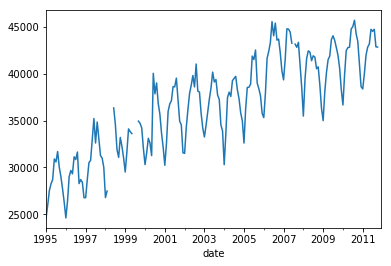

In [2]:
df = pd.read_csv('WNampa_094.csv')
df.drop(['Annual 24-hr Avg.'], axis=1, inplace=True)
dfLong = pd.melt(df, id_vars=['YEAR'], value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']).sort_values(by=['YEAR'])
dfLong.columns = ['year', 'month_name', 'count']
dfLong['day'] = 1
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
dfLong['month'] = coding(dfLong['month_name'], {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep': 9, 'Oct':10, 'Nov':11, 'Dec':12})
dfLong = dfLong.sort_values(by=['year', 'month'])
dfLong['date'] = pd.to_datetime(dfLong[['year', 'month', 'day']])
dfLong.set_index('date', inplace=True)
fig = dfLong['count'].plot()

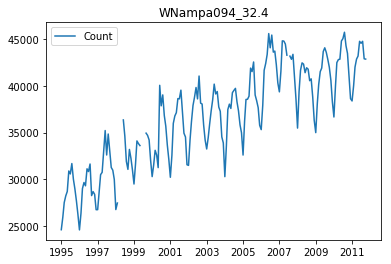

In [3]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(dfLong.index, dfLong['count'], label='Count')
plt.title('WNampa094_32.4')
ax.legend()

# fig.savefig('testplot.png')

In [4]:
#yep there is something

In [5]:
dfLongFill = dfLong.fillna(method='pad')

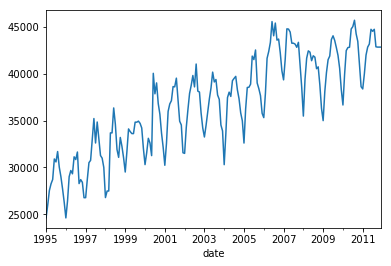

In [6]:
dfLongFill['count'].plot()

In [7]:
dfLongFill.head()

,year,month_name,count,day,month
date,,,,,
1995-01-01,1995,Jan,24632.0,1,1
1995-02-01,1995,Feb,25989.0,1,2
1995-03-01,1995,Mar,27534.0,1,3
1995-04-01,1995,Apr,28248.0,1,4
1995-05-01,1995,May,28715.0,1,5


In [7]:
time_series = dfLongFill['count']

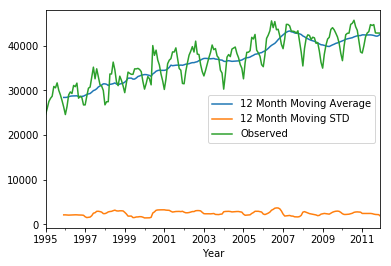

In [81]:
time_series.rolling(12).mean().plot(label='12 Month Moving Average')
time_series.rolling(12).std().plot(label='12 Month Moving STD')
time_series.plot(label='Observed')
plt.legend()
plt.xlabel('Year')
plt.savefig('Site1ma.png')

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\cfelt\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [87]:
decomp = seasonal_decompose(dfLongFill['count'])

Text(0.5,15,'Year')

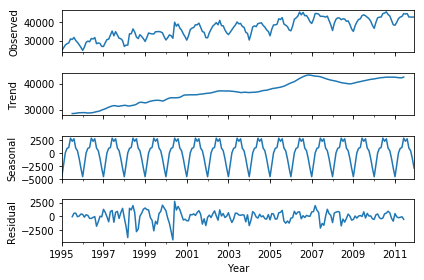

In [90]:
decomp.plot()
plt.xlabel('Year')

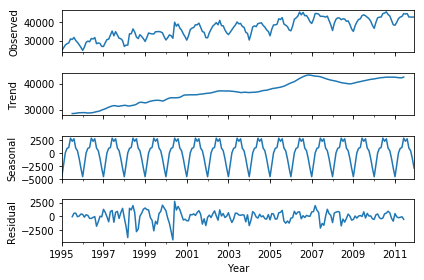

In [91]:
fig = decomp.plot()
plt.xlabel('Year')
fig.savefig('site1decomp.png')

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations used']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print('reject null hpothesis')
        print('Data has no unit root and is stationary')
    else:
        print('weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root, it is non-stationary')

In [19]:
adf_check(dfLongFill['count'])

Augmented Dicky-Fuller Test
ADF Test Statistic : -1.34079576145
p-value : 0.610307810767
# of lags : 12
Num of Observations used : 191
weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [20]:
dfLongFill['first_dif'] = dfLongFill['count'] - dfLongFill['count'].shift(1)

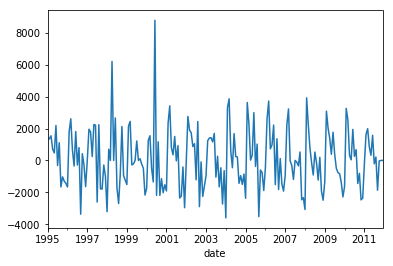

In [21]:
dfLongFill['first_dif'].plot()

In [22]:
adf_check(dfLongFill['first_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -6.02922038435
p-value : 1.43128953297e-07
# of lags : 11
Num of Observations used : 191
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [23]:
dfLongFill['season_dif'] = dfLongFill['count'] - dfLongFill['count'].shift(12)

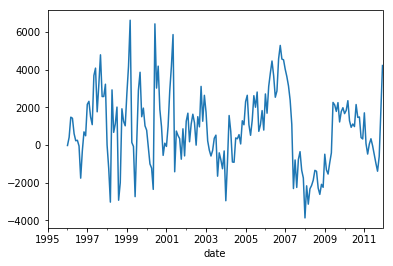

In [24]:
dfLongFill['season_dif'].plot()

In [25]:
adf_check(dfLongFill['season_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -3.90162289882
p-value : 0.00202293587508
# of lags : 12
Num of Observations used : 179
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [26]:
dfLongFill['season_first_dif'] = dfLongFill['first_dif'] - dfLongFill['first_dif'].shift(12)

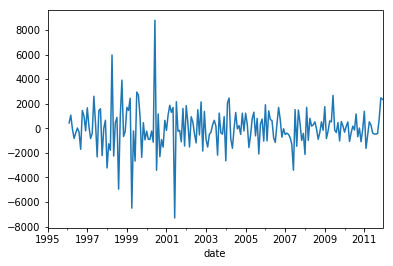

In [27]:
dfLongFill['season_first_dif'].plot()

In [28]:
adf_check(dfLongFill['season_first_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.13153496825
p-value : 1.21102162139e-05
# of lags : 15
Num of Observations used : 175
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

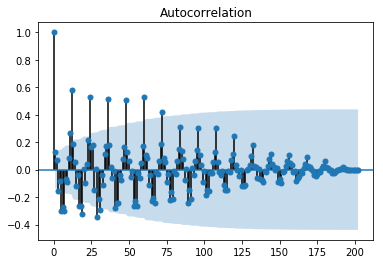

In [30]:
fig_first = plot_acf(dfLongFill['first_dif'].dropna())

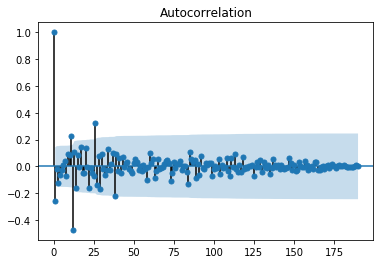

In [31]:
fig_first = plot_acf(dfLongFill['season_first_dif'].dropna())

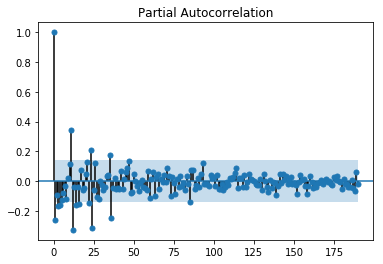

In [32]:
fig_first = plot_pacf(dfLongFill['season_first_dif'].dropna())

In [33]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### Redo Stars** after studying 

In [74]:
# model = sm.tsa.statespace.SARIMAX(dfLongFill['count'], order=(0,1,0), seasonal_order=(1,1,1,12)) #**
model = sm.tsa.statespace.SARIMAX(dfLongFill['count'], order=(0,1,1), seasonal_order=(1,1,0,12)) #**

In [75]:
results = model.fit()   #**

In [76]:
print(results.summary())  #**

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1657.675
Date:                            Tue, 13 Mar 2018   AIC                           3321.351
Time:                                    12:55:43   BIC                           3331.305
Sample:                                01-01-1995   HQIC                          3325.377
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2252      0.051      4.405      0.000       0.125       0.325
ma.S.L12      -0.8320      0.069   

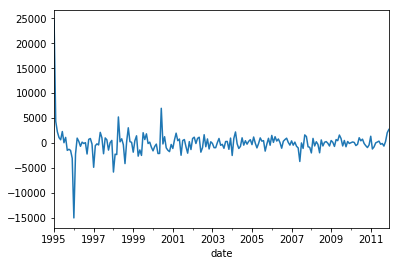

In [40]:
results.resid.plot()  #**

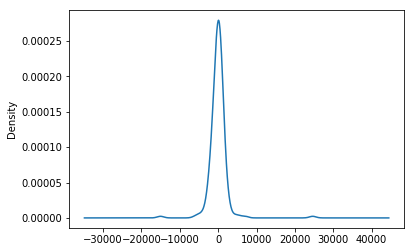

In [41]:
results.resid.plot(kind='kde') #**

In [50]:
from pandas.tseries.offsets import DateOffset 

In [115]:
future_dates = [dfLongFill.index[-1]+DateOffset(months=x) for x in range(1,96)] #add the number that reaches say 2019 #**

In [116]:
future_df = pd.DataFrame(index=future_dates, columns=dfLongFill.columns)  #**

In [117]:
final_df = pd.concat([dfLongFill, future_df])  #**

In [118]:
final_df.head()

,year,month_name,count,day,month,first_dif,season_dif,season_first_dif
1995-01-01,1995,Jan,24632.0,1,1,NaN,NaN,NaN
1995-02-01,1995,Feb,25989.0,1,2,1357.0,NaN,NaN
1995-03-01,1995,Mar,27534.0,1,3,1545.0,NaN,NaN
1995-04-01,1995,Apr,28248.0,1,4,714.0,NaN,NaN
1995-05-01,1995,May,28715.0,1,5,467.0,NaN,NaN


In [119]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 299 entries, 1995-01-01 to 2019-11-01
Data columns (total 8 columns):
year                204 non-null object
month_name          204 non-null object
count               204 non-null float64
day                 204 non-null object
month               204 non-null object
first_dif           203 non-null float64
season_dif          192 non-null float64
season_first_dif    191 non-null float64
dtypes: float64(4), object(4)
memory usage: 21.0+ KB


In [124]:
final_df['forecast']=results.predict(start=204, end=300)

In [125]:
final_df['forecast_trend'] = final_df['forecast'].fillna(dfLongFill['count'])

In [126]:
future_df.columns

Index(['year', 'month_name', 'count', 'day', 'month', 'first_dif',
       'season_dif', 'season_first_dif'],
      dtype='object')

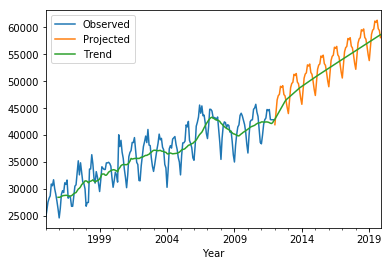

In [127]:
# predicted_trend = final_df['forecast_trend']
# predicted_trend.rolling(12).mean().plot()

final_df['count'].plot(label='Observed')
final_df['forecast'].plot(label='Projected')
final_df['forecast_trend'].rolling(12).mean().plot(label='Trend')
plt.xlabel('Year')
plt.legend()

plt.savefig('site1project.png')

# final_df['count'].rolling(12).mean().plot()
# final_df['forecast'].rolling(12).mean().plot()